In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from PIL import Image
import tensorflow as tf
from keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.keras.layers import Dropout, Input, Add, Dense, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model

In [17]:
path = Path("UTKFace")
filenames = list(map(lambda x: x.name, path.glob('*.jpg')))
print(len(filenames))
print(filenames[:3])

23708
['9_1_2_20161219204347420.jpg.chip.jpg', '36_0_1_20170117163203851.jpg.chip.jpg', '86_1_0_20170120225751953.jpg.chip.jpg']


In [18]:
np.random.seed(10)
np.random.shuffle(filenames)

age_labels, gender_labels, image_path = [], [], []

for filename in filenames:
    image_path.append(filename)
    temp = filename.split('_')
    age_labels.append(temp[0])
    gender_labels.append(temp[1])

image_path

['52_0_3_20170119205717649.jpg.chip.jpg',
 '41_0_0_20170117154651236.jpg.chip.jpg',
 '49_0_3_20170104214709125.jpg.chip.jpg',
 '5_0_2_20161219142128680.jpg.chip.jpg',
 '68_0_0_20170117172721512.jpg.chip.jpg',
 '36_0_1_20170116024228249.jpg.chip.jpg',
 '63_1_0_20170110122257987.jpg.chip.jpg',
 '45_0_4_20170103235240356.jpg.chip.jpg',
 '16_1_0_20170109213504335.jpg.chip.jpg',
 '50_1_0_20170113000711114.jpg.chip.jpg',
 '24_1_2_20170116171657075.jpg.chip.jpg',
 '30_0_0_20170117120207461.jpg.chip.jpg',
 '19_1_3_20170104222642335.jpg.chip.jpg',
 '25_1_0_20170104022944286.jpg.chip.jpg',
 '28_1_2_20170116162143001.jpg.chip.jpg',
 '27_0_1_20170116010418660.jpg.chip.jpg',
 '27_0_3_20170119211717281.jpg.chip.jpg',
 '24_1_4_20170116222729168.jpg.chip.jpg',
 '73_0_3_20170119212057504.jpg.chip.jpg',
 '25_1_0_20170116223120888.jpg.chip.jpg',
 '26_1_2_20170116233134701.jpg.chip.jpg',
 '65_1_2_20170112224125018.jpg.chip.jpg',
 '52_1_0_20170110131852751.jpg.chip.jpg',
 '40_0_3_20170104201852330.jpg.chip

In [19]:
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_path, age_labels, gender_labels
df.head()

,image,age,gender
0,52_0_3_20170119205717649.jpg.chip.jpg,52,0
1,41_0_0_20170117154651236.jpg.chip.jpg,41,0
2,49_0_3_20170104214709125.jpg.chip.jpg,49,0
3,5_0_2_20161219142128680.jpg.chip.jpg,5,0
4,68_0_0_20170117172721512.jpg.chip.jpg,68,0


image      object
age       float32
gender      int32
dtype: object


/var/folders/58/nvkqn1wd2tq7_ht3yhwmsh580000gn/T/ipykernel_16247/943332419.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.age)


<Axes: xlabel='age', ylabel='Density'>

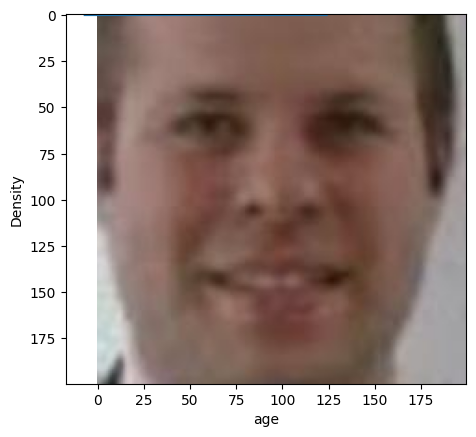

In [20]:
gender_dict = {0:"Male",1:"Female"}
df = df.astype({'age':'float32', 'gender': 'int32'})
print(df.dtypes)

img = Image.open("UTKFace/"+df.image[1])
plt.imshow(img)
sns.distplot(df.age)

20


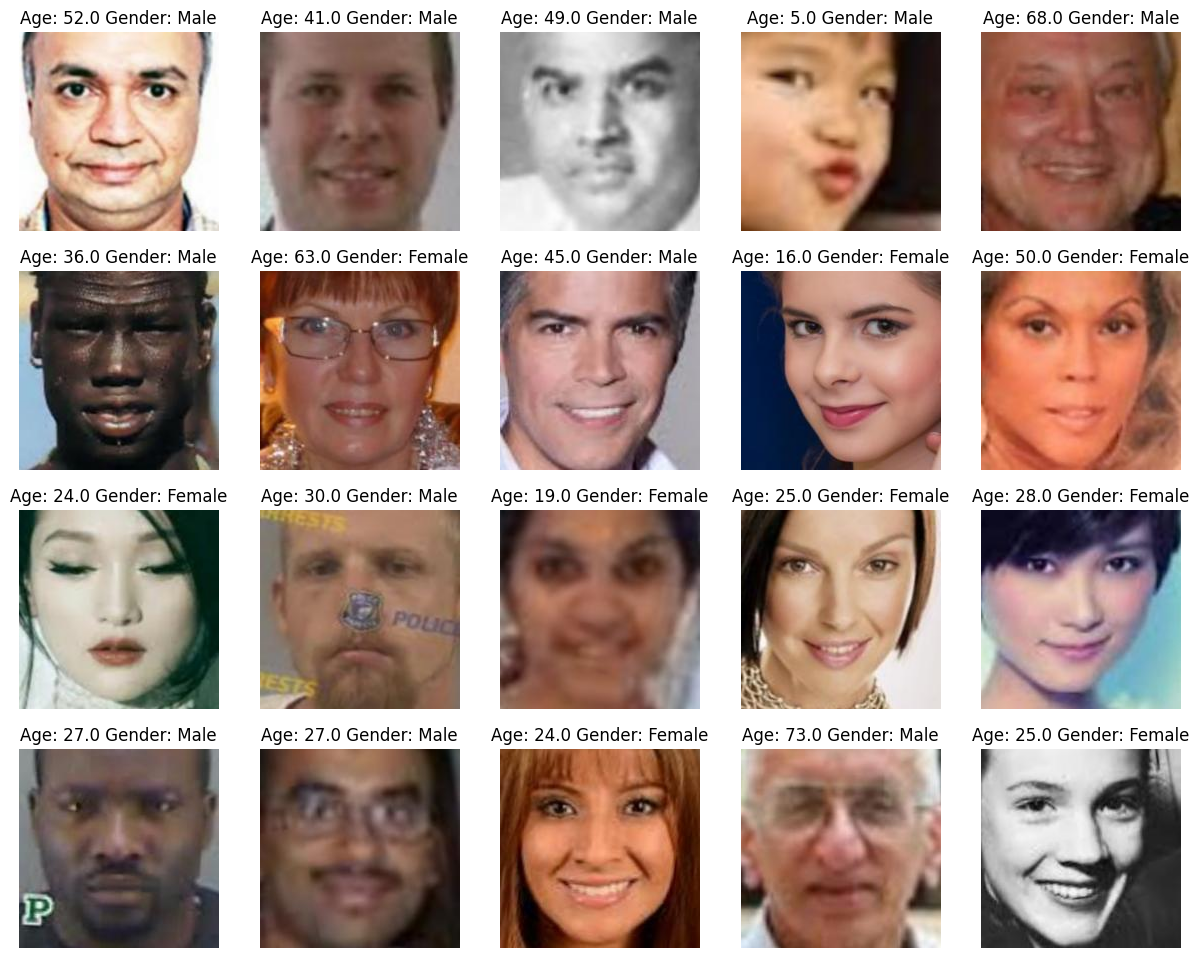

In [27]:
files = df.iloc[0:20]
print(len(files))
plt.figure(figsize=(15,15))
for index, file, age, gender in files.itertuples():
    plt.subplot(5,5, index+1)
    img = load_img("UTKFace/"+file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')

In [37]:
train, test = train_test_split(df, train_size=0.085,test_size=0.015, random_state=42)
train.head()
train.shape

(2015, 3)

In [38]:
x_train = []
for file in train.image:
    img = load_img("UTKFace/"+file, color_mode="grayscale")
    img = img.resize((128,128), Image.LANCZOS)
    img = np.array(img)
    x_train.append(img)

x_train = np.array(x_train)

x_train = x_train.reshape(len(x_train), 128,128,1)
x_train.shape
x_train = x_train/255
y_gender = np.array(train.gender)
y_age = np.array(train.age)

input_size = (128,128,1)

x_train.shape

(2015, 128, 128, 1)

In [39]:
inputs = Input((input_size))
X = Conv2D(64, (3, 3), activation='relu', kernel_initializer = glorot_uniform(seed=0))(inputs)
X = BatchNormalization(axis = 3)(X)
X = MaxPooling2D((3, 3))(X)

X = Conv2D(128, (3, 3), activation='relu')(X)
X = MaxPooling2D((2, 2), strides=(2, 2))(X)

X = Conv2D(256, (3, 3), activation='relu')(X)
X = MaxPooling2D((2, 2))(X)

X = Flatten()(X)

dense_1 = Dense(256, activation='relu')(X)
dense_2 = Dense(256, activation='relu' )(X)
dense_3 = Dense(128, activation='relu' )(dense_2)
dropout_1 = Dropout(0.4)(dense_1)
dropout_2 = Dropout(0.4)(dense_3)
output_1 = Dense(1,activation='sigmoid', name='gender_output')(dropout_1)
output_2 = Dense(1, activation='relu', name='age_output')(dropout_2)

model = Model(inputs=[inputs], outputs=[output_1,output_2])

In [40]:
model.compile(loss=['binary_crossentropy','mae'], optimizer='adam', metrics=[['accuracy'], ['accuracy']])

model.summary()

model_history = model.fit(x=x_train, y=[y_gender, y_age], batch_size = 10, epochs=20, validation_split= 0.1)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 126, 126,  │        640 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 126, 126,  │        256 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 42, 42,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 40, 40,    │     73,856 │ max_pooling2d_6[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 20, 20,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 18, 18,    │    295,168 │ max_pooling2d_7[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 9, 9, 256) │          0 │ conv2d_8[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 20736)     │          0 │ max_pooling2d_8[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 256)       │  5,308,672 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 256)       │  5,308,672 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 128)       │     32,896 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 256)       │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 128)       │          0 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gender_output       │ (None, 1)         │        257 │ dropout_4[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ age_output (Dense)  │ (None, 1)         │        129 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 11,020,546 (42.04 MB)

 Trainable params: 11,020,418 (42.04 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 18s 94ms/step - age_output_accuracy: 0.0527 - age_output_loss: 19.1417 - gender_output_accuracy: 0.5818 - gender_output_loss: 1.3519 - loss: 20.4937 - val_age_output_accuracy: 0.0446 - val_age_output_loss: 25.1609 - val_gender_output_accuracy: 0.5149 - val_gender_output_loss: 0.6779 - val_loss: 25.8027
Epoch 2/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 17s 92ms/step - age_output_accuracy: 0.0491 - age_output_loss: 14.8943 - gender_output_accuracy: 0.7061 - gender_output_loss: 0.5627 - loss: 15.4566 - val_age_output_accuracy: 0.0248 - val_age_output_loss: 24.9481 - val_gender_output_accuracy: 0.7277 - val_gender_output_loss: 0.6259 - val_loss: 25.5075
Epoch 3/20
182/182 ━━━━━━━━━━━━━━━━━━━━ 17s 96ms/step - age_output_accuracy: 0.0453 - age_output_loss: 13.4177 - gender_output_accuracy: 0.7263 - gender_output_loss: 0.5459 - loss: 13.9641 - val_age_output_accuracy: 0.0446 - val_age_output_loss: 13.8897 - val_gender_output_accuracy: 0.7327 - val_gender_output_l

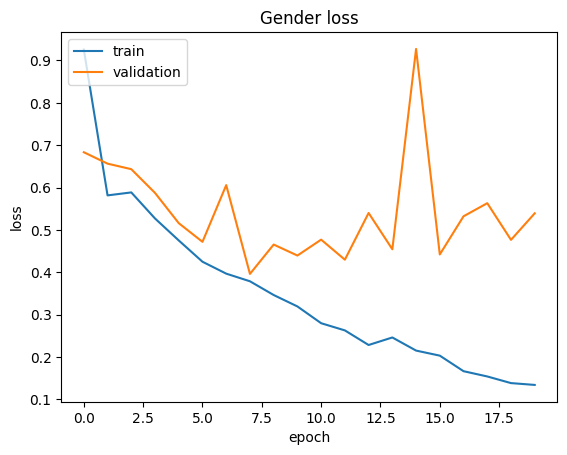

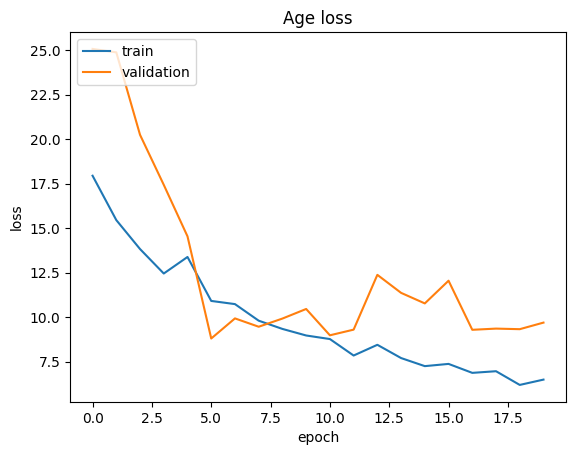

In [33]:
plt.plot(model_history.history['gender_output_loss'])
plt.plot(model_history.history['val_gender_output_loss'])
plt.title('Gender loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(model_history.history['age_output_loss'])
plt.plot(model_history.history['val_age_output_loss'])
plt.title('Age loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Original: Gender =  Female  Age =  31.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Prediction: Gender =  Female  Age =  30


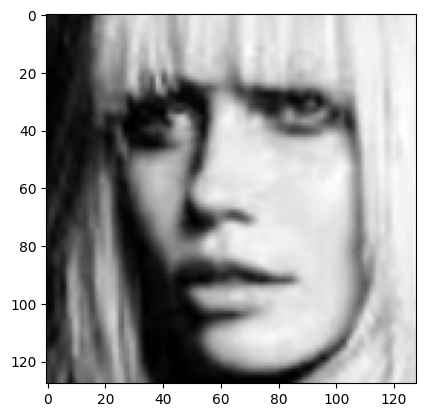

In [34]:
index=50
print("Original: Gender = ", gender_dict[y_gender[index]]," Age = ", y_age[index])

pred = model.predict(x_train[index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])

print("Prediction: Gender = ", pred_gender," Age = ", pred_age)
plt.imshow(x_train[index].reshape(128,128), cmap='gray')